# Demo: Visualization of Curvelet Coefficients in the FK domain

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from curvelops import FDCT2D

### Setup

In [2]:
nx, nz = 301, 201
data_empty = np.zeros((nx, nz))

In [3]:
nbscales = 4
nbangles_coarse = 8
allcurvelets = False

In [4]:
Cop = FDCT2D(
    data_empty.shape,
    nbscales=nbscales,
    nbangles_coarse=nbangles_coarse,
    allcurvelets=allcurvelets,
)

In [5]:
empty_fdct = Cop @ data_empty

# Convert to a curvelet struct indexed by
# [scale, wedge (angle), z, x]
empty_fdct_struct = Cop.struct(empty_fdct)

In [6]:
def create_dirac_wedge(Cop, scale, wedge):
    d = np.zeros(Cop.dims)
    wedge_only_fdct = Cop @ d

    wedge_only_fdct_struct = Cop.struct(wedge_only_fdct)
    normalization = np.sqrt(wedge_only_fdct_struct[scale][wedge].size)
    iz, ix = wedge_only_fdct_struct[scale][wedge].shape

    wedge_only_fdct_struct[scale][wedge][iz // 2, ix // 2] = normalization
    wedge_only_fdct = Cop.vect(wedge_only_fdct_struct)
    wedge_only = Cop.H @ wedge_only_fdct
    return wedge_only

#### Plot Wedges of each Scale

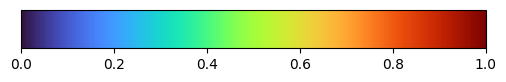

In [26]:
# Colormap to be used in all plots below
fig, ax = plt.subplots(figsize=(6, 0.5))
col_map = plt.get_cmap("turbo")
mpl.colorbar.ColorbarBase(
    ax,
    cmap=col_map,
    orientation="horizontal",
    norm=mpl.colors.Normalize(vmin=0, vmax=1),
);

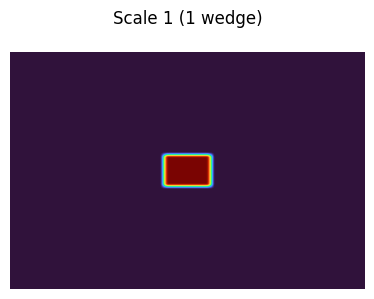

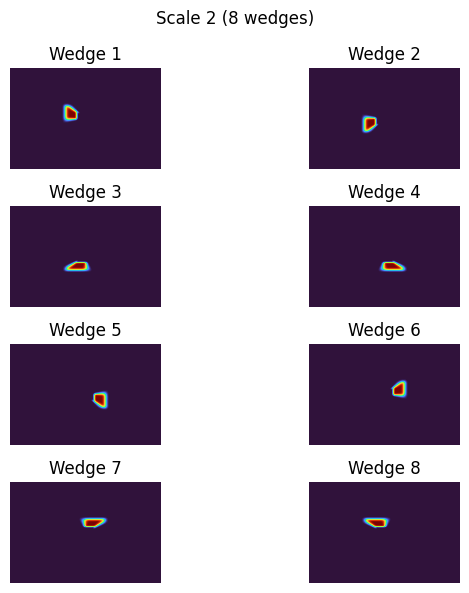

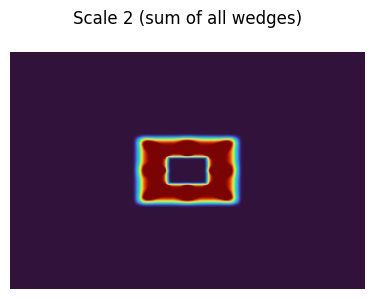

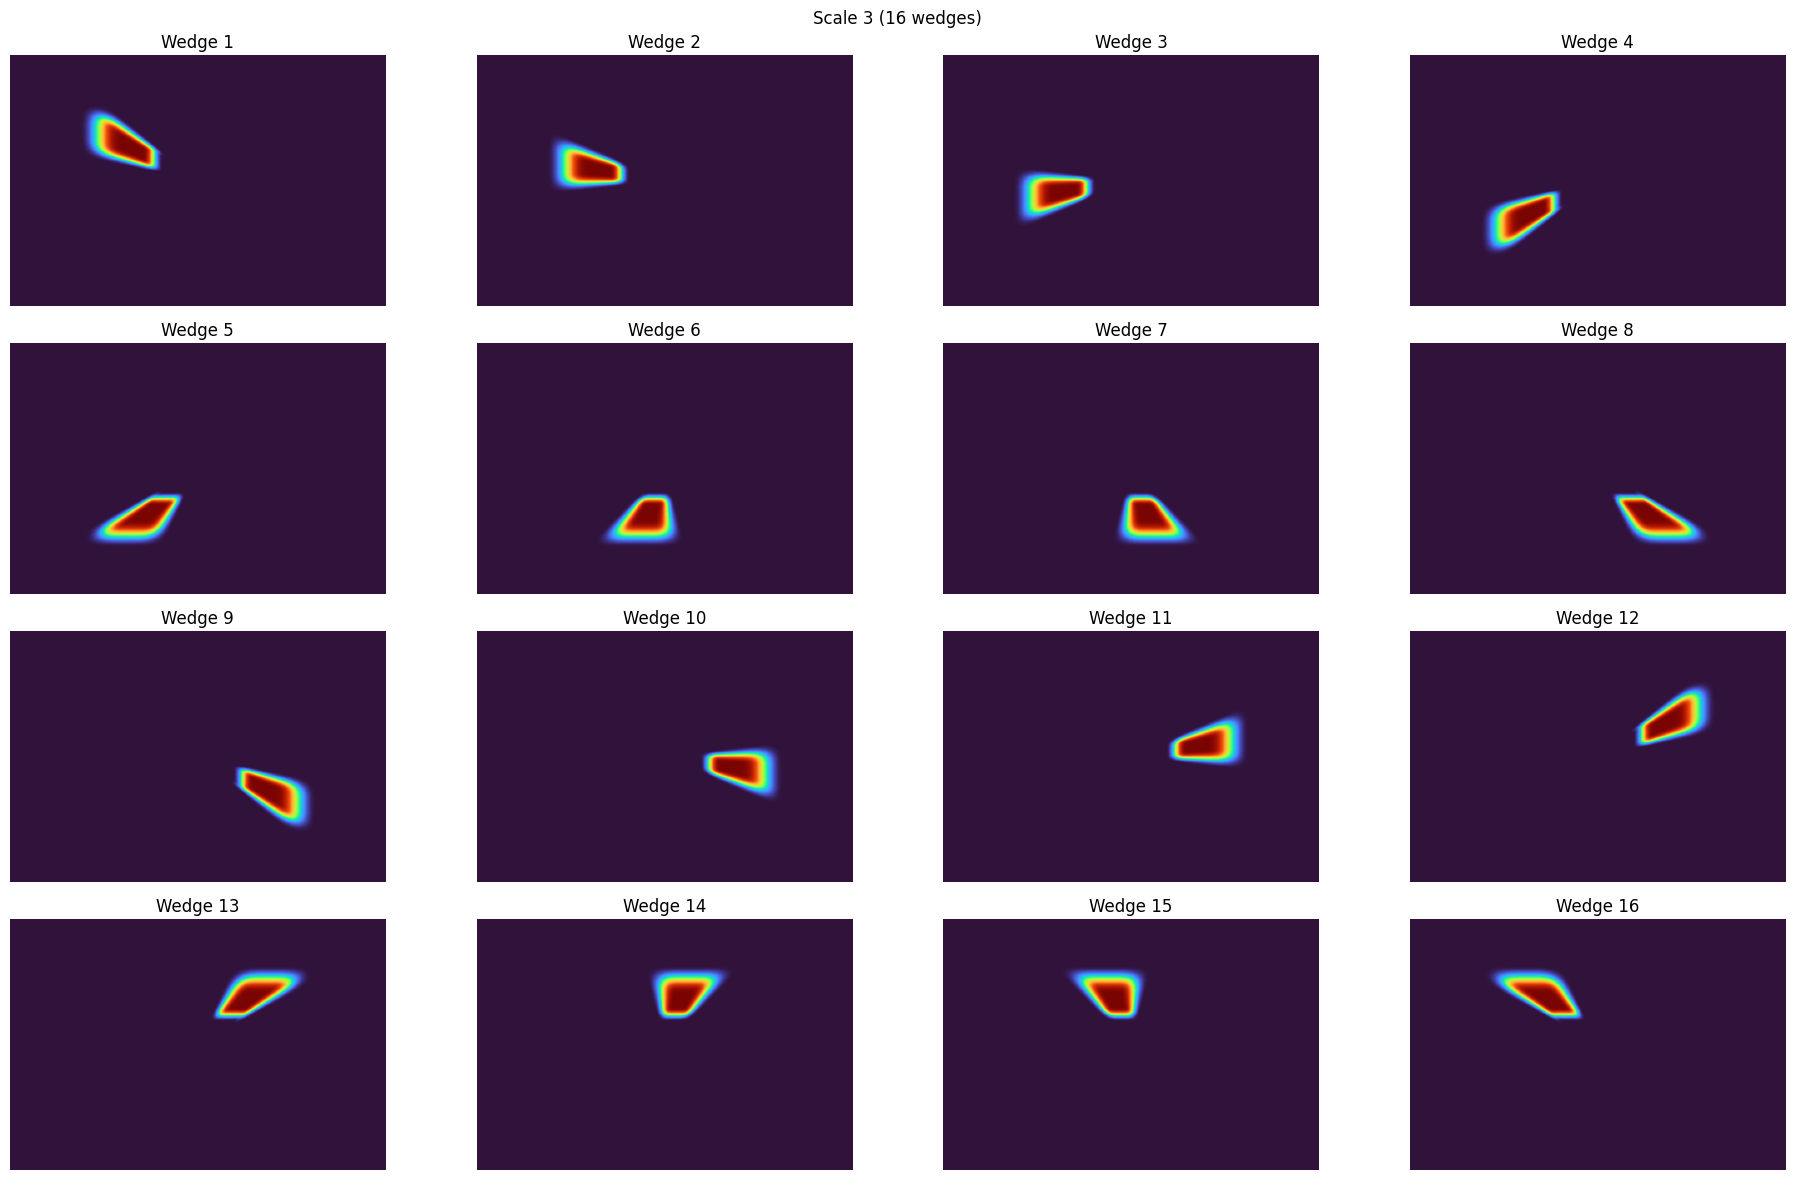

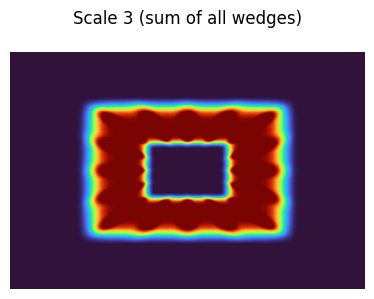

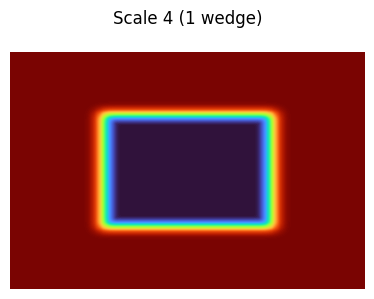

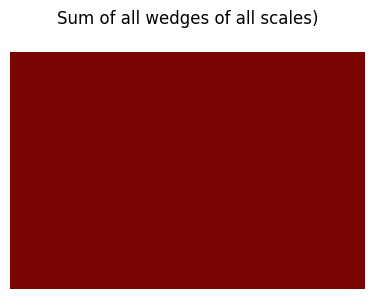

In [8]:
wedge_fk_abs = np.zeros_like(data_empty)
for j, fdct_scale in enumerate(empty_fdct_struct, start=1):
    rows = int(np.floor(np.sqrt(len(fdct_scale))))
    fig, axes = plt.subplots(
        int(np.ceil(len(fdct_scale) / rows)),
        rows,
        figsize=(5 * rows, 3 * rows),
    )
    fig.suptitle(
        f"Scale {j} ({len(fdct_scale)} wedge{'s' if len(fdct_scale) > 1 else ''})"
    )
    axes = np.atleast_1d(axes).ravel()
    wedge_scale_fk_abs = np.zeros_like(data_empty)
    for l, (fdct_wedge, ax) in enumerate(zip(fdct_scale, axes), start=1):

        dirac_wedge = create_dirac_wedge(Cop, j - 1, l - 1)
        dirac_wedge_fk = np.fft.fftshift(
            np.fft.fft2(np.fft.ifftshift(dirac_wedge), norm="ortho")
        )
        wedge_scale_fk_abs += np.abs(dirac_wedge_fk)

        ax.imshow(np.abs(dirac_wedge_fk).T, cmap="turbo", vmin=0, vmax=1)
        if len(fdct_scale) > 1:
            ax.set(title=f"Wedge {l}")
        ax.axis("off")
        fig.tight_layout()
    wedge_fk_abs += wedge_scale_fk_abs
    if len(fdct_scale) > 1:
        fig, ax = plt.subplots(figsize=(5, 3))
        fig.suptitle(f"Scale {j} (sum of all wedges)")
        ax.imshow(wedge_scale_fk_abs.T, cmap="turbo", vmin=0, vmax=1)
        ax.axis("off")
        fig.tight_layout()

fig, ax = plt.subplots(figsize=(5, 3))
fig.suptitle("Sum of all wedges of all scales)")
ax.imshow(wedge_fk_abs.T, cmap="turbo", vmin=0, vmax=1)
ax.axis("off")
fig.tight_layout()

#### Plot Dirac in Space domain

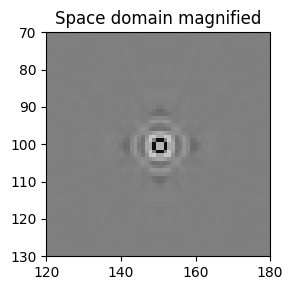

In [25]:
dirac_all_fdct_struct = Cop.struct(empty_fdct.copy())
for fdct_scale in dirac_all_fdct_struct:
    for fdct_wedge in fdct_scale:
        normalization = np.sqrt(fdct_wedge.size)
        iz, ix = fdct_wedge.shape
        fdct_wedge[iz // 2, ix // 2] = normalization * (1 + 1j)
        fdct_wedge[iz // 2 + 1, ix // 2] = normalization * (1 + 1j)
        fdct_wedge[iz // 2, ix // 2 + 1] = normalization * (1 + 1j)
        fdct_wedge[iz // 2 + 1, ix // 2 + 1] = normalization * (1 + 1j)

data_dirac = Cop.H @ Cop.vect(dirac_all_fdct_struct)
data_dirac = (data_dirac.real + data_dirac.imag) / np.sqrt(2)
vmax = 0.5 * np.sqrt(data_dirac.size)

fig, ax = plt.subplots(figsize=(5, 3))
ax.imshow(data_dirac.T, cmap="gray", vmin=-vmax, vmax=vmax)
ax.set(
    xlim=(nx // 2 - 30, nx // 2 + 30),
    ylim=(nz // 2 + 30, nz // 2 - 30),
    title="Space domain magnified",
)
fig.tight_layout()